Psuedo-code:
1. obtain image
2. create function to scale (or find one to use)
3. run through KMeans Clustering algorithm with and without normalization
4. validate results
  - reshape label array back to original dimensions
  - plot and compare with visual inspection (maybe color each label?)
5.  update team

In [1]:
# obatin image.

#install necessary packages, need to do this just once.
import sys
!{sys.executable} -m pip install earthengine-api rasterio

import ee
import rasterio
from rasterio.plot import show as showRasterio

import matplotlib.pyplot as plt
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 1.4 MB/s 


In [2]:
# Mount your google drive in google colab, to import function from tutorial.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Insert the directory
import sys
sys.path.insert(0,'/content/drive/My Drive/Colab Notebooks')

# # tutorial script
# from EarthEngineToGeoTIFF import getSentinalS2SRImage

Mounted at /content/drive


In [4]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=UDz1S9QMHmucJAD2pI5acon_la3EhA9KSoO-Jd7tvGU&tc=OwOpywcMNlQHc9vpzWaWC-9mBbr2Wr826ZhAmcfqdCc&cc=94GdnWeoLp0NQPLl2mJOUr-NJS4nSvRQg_7lNmnTPC8

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1ARtbsJoXrXNRCibmCiYWtQ2o6uRNUk2gub2n06ZXEWWPG6EjFMWhbih7Iq0

Successfully saved authorization token.


In [13]:
# Code to download images from multiple satellites.

import zipfile
import os
import requests

import numpy as np

import ee
import rasterio

def getSentinalS2_S1Image(lon, lat, sze, filename, dateMin = '2020-04-01', dateMax = '2020-04-30', vmin = 0, vmax = 3500, satellites = ['S2','S1'], 
                          bands=['B2','B3','B4','B5','B6','B7','B8','B8A','B9','B11','B12'], scale=10):
    '''    
    download image from the Sentinal S2 and S1 satellites, at the given coordinates
    
    lon : central longitude in degrees
    lat : central latitude in degrees
    sze : size of the edge of the box in degrees
    dateMin : minimum date to use for image search in year-month-day (e.g., 2020-08-01)
    dateMax : maximum date to use for image search in year-month-day (e.g., 2020-08-31)
    vMin : minimum value to select in the Sentinal image pixels (I think this should be close to 0)
    vMax : maximum value to select in the Sentinal image pixels (I think this should be close to 3000)
    filename : output filename for the GeoTIFF image
    
    Note: it's possible that the vMin and vMax values should be different for each band to make the image look nicer
    
    https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR
    https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S1_GRD
    '''


    print('Sentinel-2 MSI: MultiSpectral Instrument, Level-2A... ')
    
    # define the area of interest, using the Earth Engines geometry object
    coords = [
         [lon - sze/2., lat - sze/2.],
         [lon + sze/2., lat - sze/2.],
         [lon + sze/2., lat + sze/2.],
         [lon - sze/2., lat + sze/2.],
         [lon - sze/2., lat - sze/2.]
    ]
    print(f"Coordinates: ", coords)
    aoi = ee.Geometry.Polygon(coords)
    if 'S2' in satellites:
      # get the image using Google's Earth Engine
      db = ee.Image(ee.ImageCollection('COPERNICUS/S2_SR')\
                        .filterBounds(aoi)\
                        .filterDate(ee.Date(dateMin), ee.Date(dateMax))\
                        .sort('CLOUDY_PIXEL_PERCENTAGE')\
                        .first())
      
      # add the latitude and longitude
      db = db.addBands(ee.Image.pixelLonLat())

      # define the S2 bands to download.
      '''
      B1 - 60m pixel size - mentioned in paper, but not used in modeling... 

      B2 - 10m pixel size
      B3 - 10m pixel size
      B4 - 10m pixel size
      B8 - 10m pixel size

      B5 - 20m pixel size (red edge 1)
      B6 - 20m pixel size (red edge 2)
      B7 - 20m pixel size (red edge 3)
      B8A - 20m pixel size (red edge 4)
      B11 - 20m pixel size (SWIR1)
      B12 - 20m pixel size (SWIR2)

      '''
      bands = bands

      # export geotiff images, these go to Drive and then are downloaded locally
      for selection in bands:
          task = ee.batch.Export.image.toDrive(image=db.select(selection),
                                      description=selection,
                                      scale=scale,
                                      region=aoi,
                                      fileNamePrefix=selection,
                                      crs='EPSG:4326',
                                      fileFormat='GeoTIFF')
          task.start()

          url = db.select(selection).getDownloadURL({
              'scale': scale, # ADJUST THIS TO ACTUAL BAND MINIMUM 
              'crs': 'EPSG:4326',
              'fileFormat': 'GeoTIFF',
              'region': aoi})
      
          r = requests.get(url, stream=True)

          filenameZip = selection+'.zip'
          filenameTif = selection+'.tif'

          # unzip and write the tif file, then remove the original zip file
          with open(filenameZip, "wb") as fd:
              for chunk in r.iter_content(chunk_size=1024):
                  fd.write(chunk)

          zipdata = zipfile.ZipFile(filenameZip)
          zipinfos = zipdata.infolist()

          # iterate through each file (there should be only one)
          for zipinfo in zipinfos:
              zipinfo.filename = filenameTif
              zipdata.extract(zipinfo)
      
          zipdata.close()
          
      # create a combined RGB geotiff image, https://gis.stackexchange.com/questions/341809/merging-sentinel-2-rgb-bands-with-rasterio
      print('Creating 3-band GeoTIFF image ... ')
      
      # Define which bands are to be displayed.
      B2 = rasterio.open('B2.tif')
      B3 = rasterio.open('B3.tif')
      B4 = rasterio.open('B4.tif')
      x, y = B4.read(1).shape # this is for final np.array.

      # get the scaling
      image = np.array([B2.read(1), B3.read(1), B4.read(1)]).transpose(1,2,0)
      p2, p98 = np.percentile(image, (2,98))

      # use the B2 image as a starting point so that I keep the same parameters
      B2_geo = B2.profile
      B2_geo.update({'count': 3})

      with rasterio.open(filename, 'w', **B2_geo) as dest:
          dest.write( (np.clip(B4.read(1), p2, p98) - p2)/(p98 - p2)*255, 1)
          dest.write( (np.clip(B3.read(1), p2, p98) - p2)/(p98 - p2)*255, 2)
          dest.write( (np.clip(B2.read(1), p2, p98) - p2)/(p98 - p2)*255, 3)

      B2.close()
      B3.close()
      B4.close()
      
      # update here to output np.array, https://rasterio.readthedocs.io/en/latest/topics/reading.html
      img_spectra = np.zeros((x,y))
      for band in bands:
        img = rasterio.open(band +'.tif')
        img_spectra = np.dstack((img_spectra,np.array(img.read(1))))

      # remove the intermediate files
      for selection in bands:
          os.remove(selection + '.tif')
          os.remove(selection + '.zip')


    if 'S1' in satellites:
      print('Downloading Sentinel-1 SAR GRD: C-band Synthetic Aperture Radar Ground Range Detected, log scaling... ')
      # get the image using Google's Earth Engine
      db = ee.Image(ee.ImageCollection('COPERNICUS/S1_GRD')\
                        .filterBounds(aoi)\
                        .filterDate(ee.Date(dateMin), ee.Date(dateMax))\
                        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
                        .filter(ee.Filter.eq('instrumentMode', 'IW'))\
                        .first())
      
      # add the latitude and longitude
      db = db.addBands(ee.Image.pixelLonLat())

      # See paper, only need these two bands.
      # https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S1_GRD#bands
      bands_S1 = ['VV','VH']

      # export geotiff images, these go to Drive and then are downloaded locally
      for selection in bands_S1:
          task = ee.batch.Export.image.toDrive(image=db.select(selection),
                                      description=selection,
                                      scale=scale,
                                      region=aoi,
                                      fileNamePrefix=selection,
                                      crs='EPSG:4326',
                                      fileFormat='GeoTIFF')
          task.start()

          url = db.select(selection).getDownloadURL({
              'scale': scale, #ADJUST THIS TO ACTUAL BAND MINIMUM
              'crs': 'EPSG:4326',
              'fileFormat': 'GeoTIFF',
              'region': aoi})
      
          r = requests.get(url, stream=True)

          filenameZip = selection+'.zip'
          filenameTif = selection+'.tif'

          # unzip and write the tif file, then remove the original zip file
          with open(filenameZip, "wb") as fd:
              for chunk in r.iter_content(chunk_size=1024):
                  fd.write(chunk)

          zipdata = zipfile.ZipFile(filenameZip)
          zipinfos = zipdata.infolist()

          # iterate through each file (there should be only one)
          for zipinfo in zipinfos:
              zipinfo.filename = filenameTif
              zipdata.extract(zipinfo)
      
          zipdata.close()

      # Open relevant images.
      VV = rasterio.open('VV.tif')
      VH = rasterio.open('VH.tif')
      x,y = VH.read(1).shape # this is for final np.array.
      
      # create relevant numpy array.
      for band in bands_S1:
        img = rasterio.open(band +'.tif')
        img_spectra = np.dstack((img_spectra,np.array(img.read(1))))
        bands.append(band)

      # remove the intermediate files
      for selection in bands_S1:
          os.remove(selection + '.tif')
          os.remove(selection + '.zip')
      

    return bands, img_spectra[:,:,1:] # remove the first dimension of zeros.

In [14]:
# Sudan oil spill 1.
lat =  9.613842
lon = 29.626897
sze = 0.0167 # following grid from paper

bands, img = getSentinalS2_S1Image(lon, lat, sze, 'Sentinel2-SudanSpill1-09-28-2019.tif', dateMin='2019-09-28', dateMax='2019-09-29', satellites='S2')

# print output details.
print('bands:',bands)
print('img shape:',img.shape)

np.save('Sentinel2-SudanSpill1-09-28-2019.npy', img)

Sentinel-2 MSI: MultiSpectral Instrument, Level-2A... 
Coordinates:  [[29.618547, 9.605492], [29.635247, 9.605492], [29.635247, 9.622192], [29.618547, 9.622192], [29.618547, 9.605492]]
Creating 3-band GeoTIFF image ... 
bands: ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']
img shape: (187, 187, 11)


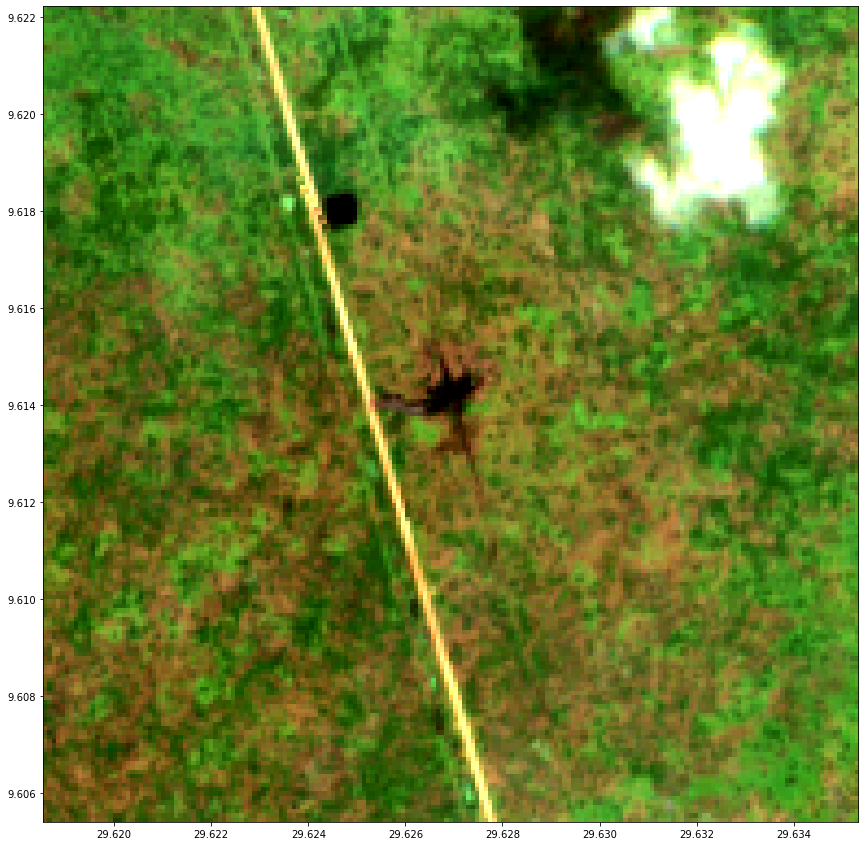

In [12]:
f,ax = plt.subplots(figsize=(15,15))

chicago = rasterio.open('Sentinel2-SudanSpill1-09-28-2019.tif')
showRasterio(chicago.read(), ax = ax, transform=chicago.transform)

f.savefig('SudanSpill1.png', bbox_inches='tight')

chicago.close()

In [29]:
# Hospah oil spill 2.
lat2 =  35.73283
lon2 = -107.74805
sze2 = 0.0167 # following grid from paper

bands, img = getSentinalS2_S1Image(lon2, lat2, sze2, 'Sentinel2-HospahSpill2-08-15-2018.tif', dateMin='2018-12-15', dateMax='2018-12-30', satellites='S2')

# print output details.
print('bands:',bands)
print('img shape:',img.shape)

np.save('Sentinel2-HospahSpill2-08-15-2018.npy', img)

Sentinel-2 MSI: MultiSpectral Instrument, Level-2A... 
Coordinates:  [[-107.7564, 35.72448], [-107.73970000000001, 35.72448], [-107.73970000000001, 35.74118], [-107.7564, 35.74118], [-107.7564, 35.72448]]
Creating 3-band GeoTIFF image ... 
bands: ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']
img shape: (186, 187, 11)


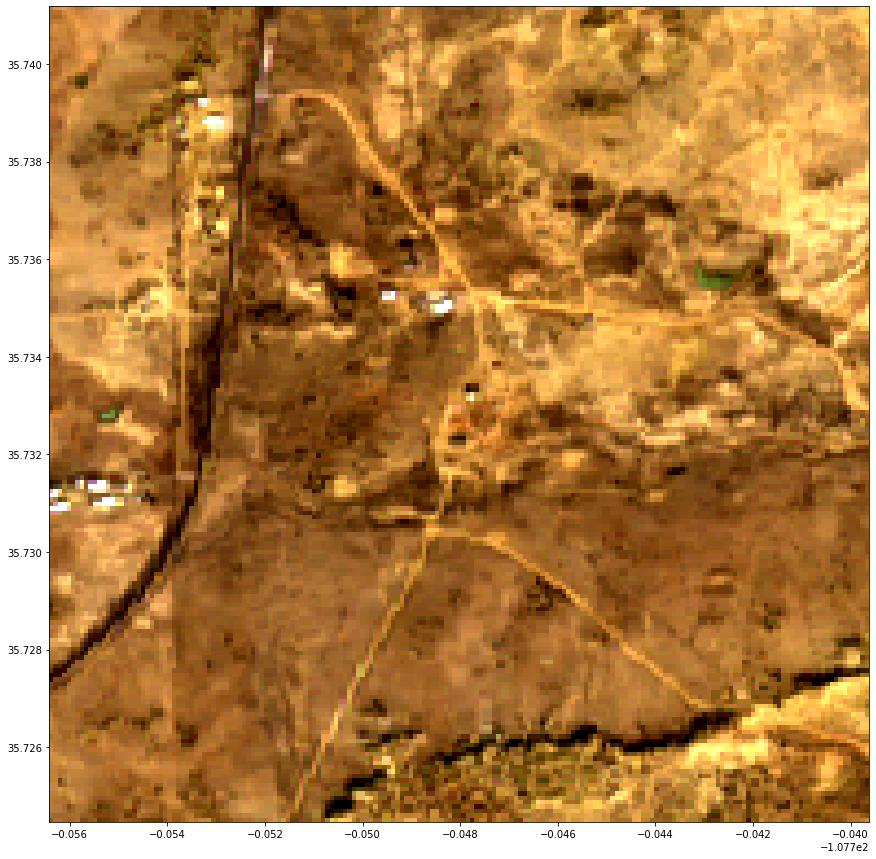

In [30]:
f,ax = plt.subplots(figsize=(15,15))

hospah = rasterio.open('Sentinel2-HospahSpill2-08-15-2018.tif')
showRasterio(hospah.read(), ax = ax, transform=hospah.transform)

f.savefig('HospahSpill2.png', bbox_inches='tight')

hospah.close()

In [ ]:
def scale(arr):
  # scales the values of a 2d array between 0 and 1.

  flat = arr.ravel()
  top, bottom = max(flat), min(flat)
    
  scaled = []
  for pix in flat:
    new = (pix-bottom) / (top-bottom)
    scaled.append(new)
    
  scaled_arr = np.array(scaled).reshape(arr.shape)
  return scaled_arr


#scaled_arr = scale(img[:,:,0]) #DELETE LATER
#plt.hist(scaled_arr.ravel(), bins=20) #DELETE LATER
#plt.tight_layout() #DELETE LATER

In [ ]:
# scale dimensions of image
img_scaled = np.zeros(img.shape)
#print(img_scaled.shape) #DELETE LATER

for layer in range(img.shape[2]):
  #print("layer number",layer) #DELETE LATER
  #print("layer", layer,"max:",img[:,:,layer].max()) #DELETE LATER
  #print("layer", layer,"min:",img[:,:,layer].min()) #DELETE LATER
  img_scaled[:,:,layer] = scale(img[:,:,layer])

In [ ]:
# Reshape image array for clustering.

kmeans_input = img_scaled.reshape(187*187,11)
#print(kmeans_input.shape) #(34969, 11) #DELETE LATER

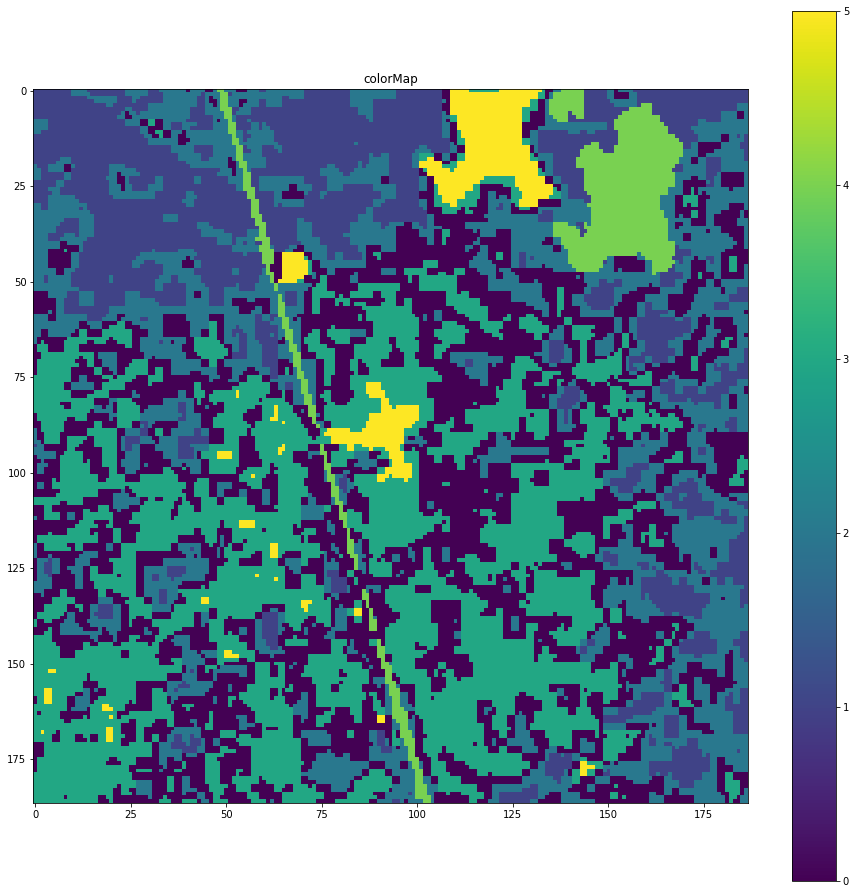

In [ ]:
# Try KMeans Clustering with scaling.
from sklearn.cluster import KMeans
Kmean = KMeans(n_clusters=6, random_state=30)
#Kmean = KMeans(n_clusters=6, random_state=30, n_init=100, max_iter=500, tol=1e-7, algorithm='auto')
Kmean.fit(kmeans_input)


# Reshape model labels for displaying output.
Kmean.labels_.shape
labels = Kmean.labels_.reshape(187,187)

# Display labels
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16,16))

ax = fig.add_subplot(111)
ax.set_title('colorMap')
plt.imshow(Kmean.labels_.reshape(187,187))
ax.set_aspect('equal')

plt.colorbar(orientation='vertical')
plt.show()

Psuedo-code:

1. Create function to manually remove non-oil spill labels.
2. Manually remove non-oil spills
3. Split modified image and label arrays into balanced test/train datasets based on labels.
4. Train and test a Random Forest model.
5. Visually display labels (highlight oil spill, all others shade of blue).

(array([9989.,    0.,    0.,    0., 5604.,    0.,    0.,    0., 7606.,
           0.,    0.,    0., 9529.,    0.,    0.,    0., 1290.,    0.,
           0.,  951.]),
 array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
        2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  ]),
 <a list of 20 Patch objects>)

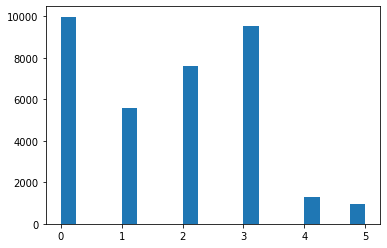

In [ ]:
# EDA for distribution of labels
plt.hist(labels.ravel(), bins=20)

# Cluster labels seem to be:
# 0 - light vegetation
# 1 - dark vegetation
# 2 - mixed dirt and vegetation
# 3 - dirt
# 4 - cloud/road
# 5 - oil


In [ ]:
# Function to manually remove non-oil spills labels.
def scrub(labels, fill_value=1, replace_value=5, corners=[0,1,0,1]):
  xmin = corners[0]
  xmax = corners[1]
  ymin = corners[2]
  ymax = corners[3]

  mod_labels = labels

  for xidx in range(xmin,xmax):
    for yidx in range(ymin,ymax):
      #print(mod_labels[xidx,yidx])
      if mod_labels[xidx,yidx] == fill_value:
        mod_labels[xmin:xmax,ymin:ymax] = replace_value  

  #for label in mod_labels[xmin:xmax,ymin:ymax]:
    #print("label:",label)
    #if label == fill_value:
      #mod_labels[xmin:xmax,ymin:ymax] = replace_value
  return mod_labels

In [ ]:
labels[0,:]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 0, 0, 2, 4, 4, 2, 2, 2, 0, 0, 0, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 5,
       5, 5, 5, 5, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 3, 0, 0, 2, 2, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 2, 2, 0, 2,
       2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [ ]:
# test scrub
corners =[0,35,100,150]
test = scrub(labels,fill_value=5, replace_value=1,corners=corners)

# Replot labels to confirm
test[0,:]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 0, 0, 2, 4, 4, 2, 2, 2, 0, 0, 0, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 2,
       2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

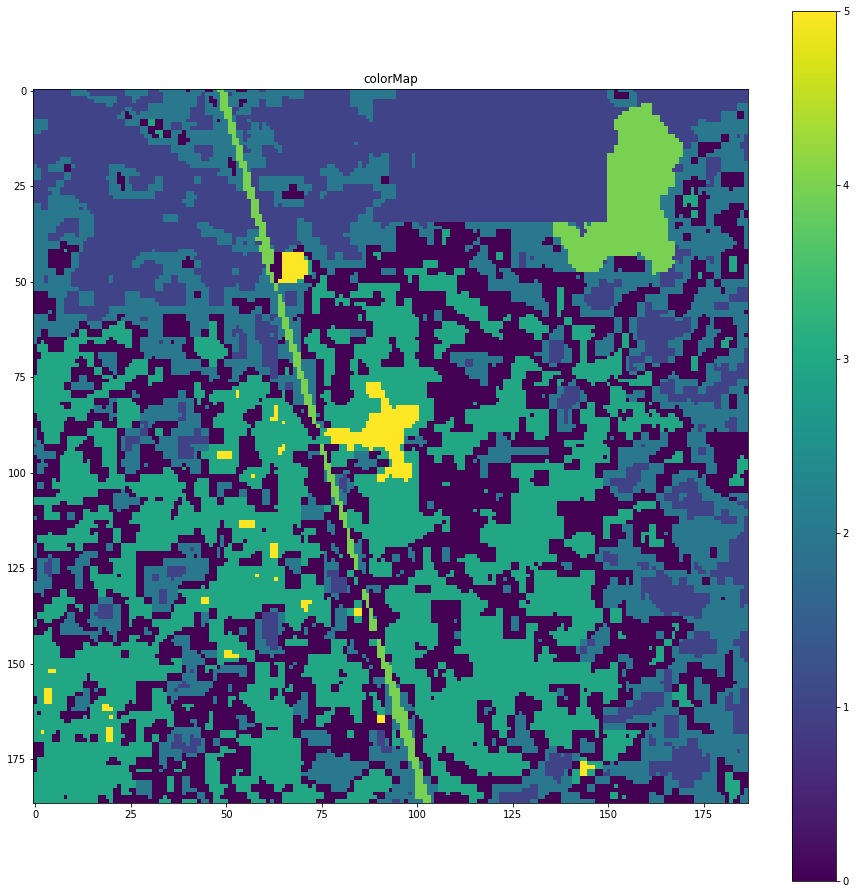

In [ ]:
# Display SCRUBBED labels
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16,16))

ax = fig.add_subplot(111)
ax.set_title('colorMap')
plt.imshow(test)
ax.set_aspect('equal')

plt.colorbar(orientation='vertical')
plt.show()

In [ ]:
# Obtain test/train splits for data (X) and labels (Y).
labels_list = [0,1,2,3,4,5]
labels_flat = labels.ravel().reshape(-1,1)
img_flat = kmeans_input
test_split = 0.3


X_train = np.zeros((1,11)) # train data
X_test = np.zeros((1,11)) # test data

y_train = [] # train labels
y_test = [] # test lbels

for label in labels_list:
  labels_all = np.where(labels_flat == label)[0] # find all indices of a particular label.
  labels_test_idx = np.random.choice(labels_all.shape[0], int(np.ceil(labels_all.shape[0]*test_split)), replace=False) #create list of test indices by randomly selecting from all indices.
  labels_train_idx = np.delete(labels_all, labels_test_idx) #create list of train indices by deleting test indices.

  # Append to test/train numpy arrays for data and labels.
  # Data arrays update.

  counter = 0
  for idx in labels_test_idx:
    X_test = np.append(X_test, img_flat[idx].reshape(1,-1), axis=0)
    y_test.append(label)
    counter +=1

  counter = 0
  for idx in labels_train_idx:
    X_train = np.append(X_train, img_flat[idx].reshape(1,-1), axis=0)
    y_train.append(label)
    counter +=1

  # Labels lists update.
#  for label in range(len(labels_train_idx)):
    #y_train.append(label)
  #for label in range(len(labels_test_idx)):
    #y_test.append(label)

# Once done looping:
# Turn test lists into np arrays.
y_test = np.array(y_test)
y_train = np.array(y_train)

# Remove initializing element in data arrays.
X_train = np.delete(X_train, 0, axis=0)
X_test = np.delete(X_test, 0, axis=0)


# Shuffle final numpy arrays.
from sklearn.utils import shuffle
y_train, X_train = shuffle(y_train, X_train, random_state=10)
y_test, X_test = shuffle(y_test, X_test, random_state=10)


# THIS IS FOR VALIDATION
#y_train.shape #(24476,)
#X_train.shape #(24476, 11)

#y_test.shape #(10493,)
#X_test.shape #(10493, 11)

In [ ]:
# Test for alternate train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(img_flat, labels_flat, test_size=0.2, random_state=0)

# THIS IS FOR VALIDATION
#y_train.shape #(27975,1)
#X_train.shape #(27975,11)

#y_test.shape #(6994, 1)
#X_test.shape #(6994, 11)

In [ ]:
# Train and test OOTB Random Forest Classifier.
from sklearn.ensemble import RandomForestClassifier
RFClassifier = RandomForestClassifier(n_estimators=20, random_state=0)
RFClassifier.fit(X_train, y_train)
y_pred = RFClassifier.predict(X_test)


# Evalute.
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("confusion matrix:\n",confusion_matrix(y_test,y_pred))
print("classification report:\n",classification_report(y_test,y_pred))
print("accuracy score:\n",accuracy_score(y_test, y_pred))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


confusion matrix:
 [[1910    0   30   34    0    0]
 [  15 1307   24    1    1    0]
 [  40   19 1426    0    1    0]
 [  34    1    0 1871    0    4]
 [   1    4    3    0  207    0]
 [   0    0    0    3    0   58]]
classification report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96      1974
           1       0.98      0.97      0.98      1348
           2       0.96      0.96      0.96      1486
           3       0.98      0.98      0.98      1910
           4       0.99      0.96      0.98       215
           5       0.94      0.95      0.94        61

    accuracy                           0.97      6994
   macro avg       0.97      0.96      0.97      6994
weighted avg       0.97      0.97      0.97      6994

accuracy score:
 0.9692593651701459


In [ ]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import xgboost as xgb

In [ ]:
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(X_train,y_train)
y_pred_xgb = xgb_classifier.predict(X_test)


# Evalute.
print("confusion matrix:\n",confusion_matrix(y_test,y_pred_xgb))
print("classification report:\n",classification_report(y_test,y_pred_xgb))
print("accuracy score:\n",accuracy_score(y_test, y_pred_xgb))

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


confusion matrix:
 [[1910    2   25   34    3    0]
 [  23 1250   55    7   13    0]
 [  34   14 1438    0    0    0]
 [  31    2    0 1874    0    3]
 [   0    7    5    0  203    0]
 [   0    1    0    5    0   55]]
classification report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.96      1974
           1       0.98      0.93      0.95      1348
           2       0.94      0.97      0.96      1486
           3       0.98      0.98      0.98      1910
           4       0.93      0.94      0.94       215
           5       0.95      0.90      0.92        61

    accuracy                           0.96      6994
   macro avg       0.96      0.95      0.95      6994
weighted avg       0.96      0.96      0.96      6994

accuracy score:
 0.9622533600228768


In [ ]:
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='rbf') # 0.9736917357735202
#clf = svm.SVC(kernel='linear') # 0.8989133543036889
#clf = svm.SVC(kernel='poly') # 0.9275092936802974
#clf = svm.SVC(kernel='sigmoid') # 0.4376608521589934
#clf = svm.SVC(kernel='precomputed') # error, because matrix must be square...

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred_svm = clf.predict(X_test)

# Evalute.
print("confusion matrix:\n",confusion_matrix(y_test,y_pred_svm))
print("classification report:\n",classification_report(y_test,y_pred_svm))
print("accuracy score:\n",accuracy_score(y_test, y_pred_svm))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


confusion matrix:
 [[1966    2    2    3    1    0]
 [  30 1211   66    9   29    3]
 [   8    7 1470    0    1    0]
 [   2    5    0 1903    0    0]
 [   0    7    1    0  207    0]
 [   0    2    0    6    0   53]]
classification report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1974
           1       0.98      0.90      0.94      1348
           2       0.96      0.99      0.97      1486
           3       0.99      1.00      0.99      1910
           4       0.87      0.96      0.91       215
           5       0.95      0.87      0.91        61

    accuracy                           0.97      6994
   macro avg       0.95      0.95      0.95      6994
weighted avg       0.97      0.97      0.97      6994

accuracy score:
 0.9736917357735202


Run model against oil spill site 2 data.

Psuedo-code: Figure out if balancing the test/train sets is appropriate.

1. read.

Psuedo-code: perform analysis on different cluster types.

1. find averages
2. plot radar charts

In [ ]:
# EDA for cluster characteristics.
labels_flat = labels.ravel().reshape(-1,1)
img_flat = kmeans_input

#labels_flat.shape # (34969, 1) # DELETE LATER
#img_flat.shape # (34969, 11) # DELETE LATER

(34969, 1)

(array([1., 0., 1., 1., 1., 0., 1., 0., 2., 4.]),
 array([0.1180845 , 0.16325672, 0.20842894, 0.25360117, 0.29877339,
        0.34394561, 0.38911783, 0.43429006, 0.47946228, 0.5246345 ,
        0.56980673]),
 <a list of 10 Patch objects>)

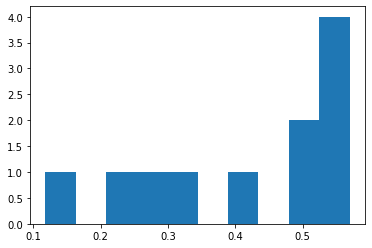

In [ ]:
# Get distribution of particular label.

labels_0_all = np.where(labels_flat == 0)[0]
#labels_0_all[0].shape #(9989,) # DELETE LATER
#print(labels_0_all[0:10]) # DELETE LATER

analysis = np.zeros((labels_0_all.shape[0],img_flat.shape[1]))
#print(analysis.shape)#(9989, 11) # DELETE LATER

counter = 0
for idx in labels_0_all:
  analysis[counter,:] = img_flat[idx,:]
  counter += 1

# Take mean along dimensions
means = np.mean(analysis,axis=0)

plt.hist(means)

In [ ]:
# AR for someone...chart some radar charts!

#https://www.geeksforgeeks.org/star-charts-in-python/
#https://matplotlib.org/stable/gallery/specialty_plots/radar_chart.html

Spare code cells below. Can probably delete/ignore these...

In [ ]:
#EDA for normalization step.


import matplotlib.pyplot as plt
import numpy as np

titles = bands
f,a = plt.subplots(len(bands),2)
a = a.ravel()
for idx,ax in enumerate(a):
  print("layer max:",img[:,:,layer].max())
  print("layer max:",img[:,:,layer].min())
  ax.hist(img[idx])


#plt.hist(img[:,:,layer].ravel(), bins=20)

arr = preprocessing.normalize(img[:,:,layer], norm='l2')

print(img[:,:,layer].shape)
print(arr.shape)
print("normed layer max:",arr.max())
print("normed layer min:",arr.min())
print(arr.shape)

plt.hist(arr, bins=20)
plt.tight_layout()

In [ ]:
# EDA for single layer normalization
from sklearn import preprocessing
layer = 0
print(img[:,:,layer])
print("layer max:",img[:,:,layer].max())
print("layer min:",img[:,:,layer].min())

#plt.hist(img[:,:,layer].ravel(), bins=20)

arr_ravel = img[:,:,layer].ravel()
arr_ravel_reshape = arr_ravel.reshape(-1,1)
arr_ravel_normed = preprocessing.normalize(arr_ravel_reshape,norm='l2',axis=0) #https://datascience.stackexchange.com/questions/65360/why-cant-i-normalize-my-data-using-preprocessing-normalize

print(arr_ravel_normed)
print("layer max:",arr_ravel_normed.max())
print("layer min:",arr_ravel_normed.min())
print(arr_ravel_normed.reshape(187,187))

plt.hist(arr_ravel_normed, bins=20)

In [ ]:
# normalize the image layers.
# notes on normalization: https://www.kaggle.com/code/residentmario/l1-norms-versus-l2-norms/notebook

img_norm = np.zeros(img.shape)
print(img_norm.shape)

for layer in range(img.shape[2]):
  print("layer number",layer)
  print("layer", layer,"max:",img[:,:,layer].max())
  print("layer", layer,"min:",img[:,:,layer].min())
  img_norm[:,:,layer] = preprocessing.normalize(img[:,:,layer].ravel().reshape(-1,1),norm='l2',axis=0).reshape(img.shape[:2])

  print("normed layer", layer,"max:",img_norm[:,:,layer].max())
  print("normed layer", layer,"min:",img_norm[:,:,layer].min())

In [ ]:
# Obtain balanced test/train splits for data (X) and labels (Y).
labels_list = [0,1,2,3,4,5]
labels_flat = labels.ravel().reshape(-1,1)
img_flat = kmeans_input



labels_0_all = np.where(labels_flat == 0)[0]
#labels_0_all[0].shape #(9989,) # DELETE LATER
#print(labels_0_all[0:10]) # DELETE LATER

test_split = 0.3

labels_0_test_idx = np.random.choice(labels_0_all.shape[0], int(np.ceil(labels_0_all.shape[0]*test_split)), replace=False)  
#labels_0_test_idx.shape # (2997,)
labels_0_train_idx = np.delete(labels_0_all, labels_0_test_idx)

#analysis = np.zeros((labels_0_all.shape[0],img_flat.shape[1]))
##print(analysis.shape)#(9989, 11) # DELETE LATER

#counter = 0
#for idx in labels_0_all:
#  analysis[counter,:] = img_flat[idx,:]
#  counter += 1